In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prepare import *
from catboost import CatBoostRegressor, Pool
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from metrics import *

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

In [2]:
def evaluate(model, X, y):
    preds = model.predict(X)

    res = np.clip(invert(preds), 0 , 8000)
    #print("Y ", y, "\nPreds ", invert(preds))
    #print("MSE: " + str(mean_squared_error(res, invert(y))))
    print("SMAPE: " + str(smape(res, invert(y))))

In [4]:
data = pd.read_csv("../data/train.csv")

In [5]:
reg = fit_regressor(data)

y = np.log1p(data["Sales"])

#make a guess about price
data["Approximate"] = get_approximation(reg, data)

# prepare data
X = prepare_data(data)

0.8271043986147537 [1.75490732]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = remove_outliers_split(X_train, y_train)
X_train.head()

Int64Index([22433, 3166, 18475, 11982, 10124, 14166, 16131, 18146], dtype='int64')


Brand                              Seller  Comments  \
3214    Juliabeauty  Калашников Андрей Александрович ИП  4.898979   
8203        RedVerg                     ТМК ОПТТОРГ ООО  2.645751   
13925       HDFREZA  Мыслицкий Владимир Вячеславович ИП  1.732051   
18650       Ergolux       Энергосистемы и Технологии АО  0.000000   
10806  Healthy Life                     КМД-ПАРТНЁР ООО  1.000000   

       Average price  Days in stock  Days with sales  Rating  Basic Sale  \
3214     3336.666667           31.0         5.385165     2.0        55.0   
8203     3090.777778            7.0         2.828427     2.0        35.0   
13925     149.000000           17.0         2.828427     2.0         0.0   
18650     732.000000           31.0         0.000000    -3.0        50.0   
10806    3030.200000           15.0         2.000000     2.0        50.0   

       Approximate  Discount          Section             SubSection  \
3214     79.980882       0.0  Бытовая техника     Красота и здоровье   
8203     16.284344     317.0  Бытовая техника  Климатическая техника   
13925    16.284344       0.0  Бытовая техника     Красота и здоровье   
18650     0.000000       0.0  Бытовая техника        Садовая техника   
10806     8.346205     366.0  Бытовая техника     Красота и здоровье   

                  ExtraSection  Price scale  
3214   Массажеры электрические    -0.490341  
8203            Тепловые пушки    -0.473523  
13925       Фрезы для маникюра    -0.493687  
18650       Лампы от насекомых    -0.423383  
10806  Массажеры электрические    -0.488433

In [7]:
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]
# sanity check
X_train.iloc[:, cat_features]

Brand                              Seller          Section  \
3214    Juliabeauty  Калашников Андрей Александрович ИП  Бытовая техника   
8203        RedVerg                     ТМК ОПТТОРГ ООО  Бытовая техника   
13925       HDFREZA  Мыслицкий Владимир Вячеславович ИП  Бытовая техника   
18650       Ergolux       Энергосистемы и Технологии АО  Бытовая техника   
10806  Healthy Life                     КМД-ПАРТНЁР ООО  Бытовая техника   
...             ...                                 ...              ...   
21575         Marta                         ВАЛЕРИЯ ООО  Бытовая техника   
5390         CADENA                   ООО СПУТНИК ТРЕЙД  Бытовая техника   
860         Endever                        ВЛКГРУПП ООО  Бытовая техника   
15795    MEDICINECA    Драганов Александр Алексеевич ИП  Бытовая техника   
23654         HUAYU              Дулгер Дарья Сергеевна  Бытовая техника   

                  SubSection             ExtraSection  
3214      Красота и здоровье  Массажеры электрические  
8203   Климатическая техника           Тепловые пушки  
13925     Красота и здоровье       Фрезы для маникюра  
18650        Садовая техника       Лампы от насекомых  
10806     Красота и здоровье  Массажеры электрические  
...                      ...                      ...  
21575       Техника для дома         Техника для дома  
5390        Техника для дома     Пульты телевизионные  
860         Техника для дома                    Утюги  
15795     Красота и здоровье           Пульсоксиметры  
23654       Техника для дома     Пульты телевизионные  

[20041 rows x 5 columns]

In [8]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)

org_params = {
    'iterations': 2000,
    'learning_rate': 0.08,
    'eval_metric': 'SMAPE',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'loss_function': 'MAPE',
    'od_type': 'Iter',
    'od_wait': 1000,
    'one_hot_max_size': 20,
    'l2_leaf_reg': 100,
    'depth': 8,
    'rsm': 0.6,
    'random_strength': 2,
    'bagging_temperature': 10,
    #'task_type': "GPU",  
    #'devices': '0:1'
}

cat_model = CatBoostRegressor(**org_params)
cat_model.fit(train_pool, eval_set=dev_pool, verbose=0, plot=True, early_stopping_rounds=120)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [9]:
evaluate(cat_model, X_train, y_train)

evaluate(cat_model, X_test, y_test)

SMAPE: 18.763700256752287
SMAPE: 20.815143786551126


In [10]:
cat_model.get_feature_importance(prettified = True)


Feature Id  Importances
0   Days with sales    45.847803
1       Approximate    33.866976
2          Comments     8.170454
3     Days in stock     6.389345
4      ExtraSection     1.450315
5            Rating     1.034628
6        Basic Sale     0.746710
7          Discount     0.743372
8     Average price     0.732894
9       Price scale     0.638048
10       SubSection     0.379455
11            Brand     0.000000
12           Seller     0.000000
13          Section     0.000000

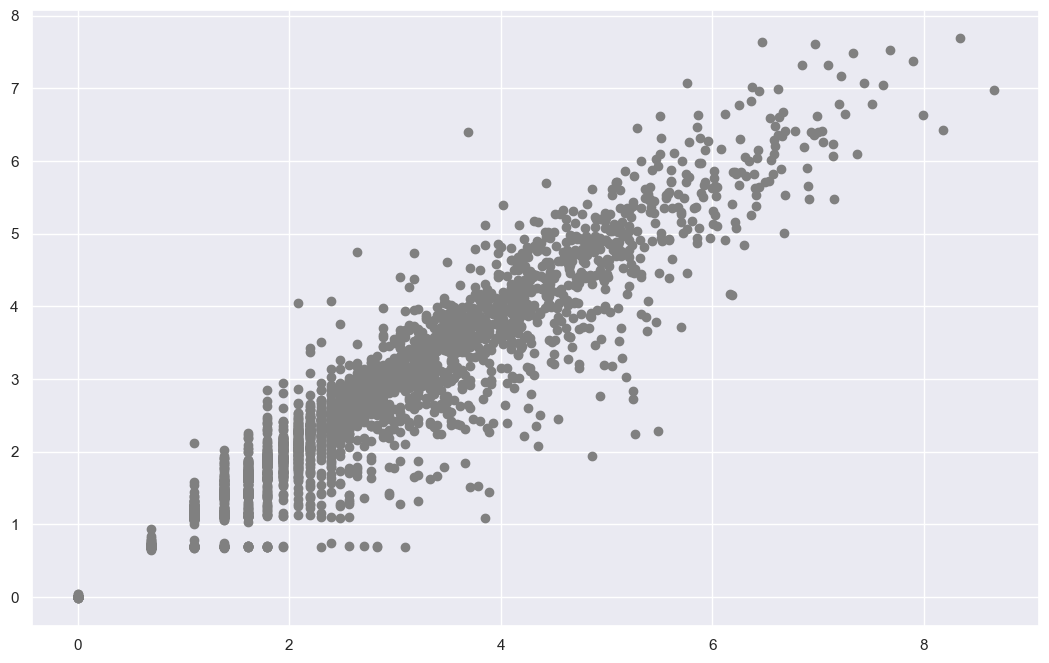

In [11]:
plt.figure(figsize=(13,8))
plt.scatter(y_test, cat_model.predict(X_test), color='gray')

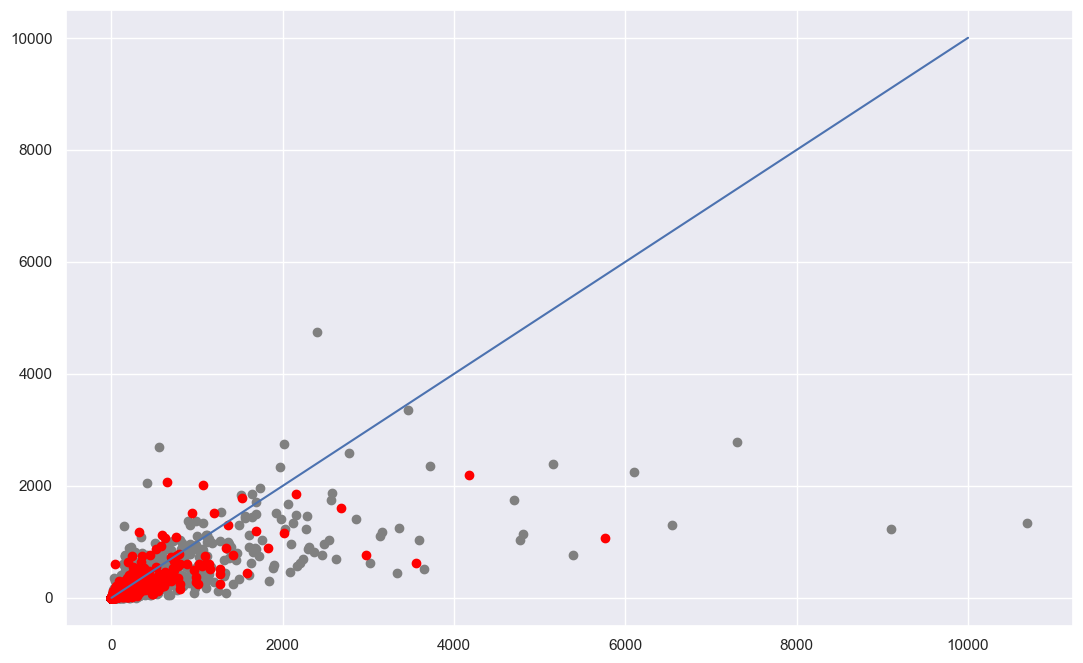

In [12]:
plt.figure(figsize=(13,8))

plt.plot(np.linspace(0, 10000, 2), np.linspace(0, 10000, 2), c = 'b')

plt.scatter(invert(y_train), invert(cat_model.predict(X_train)), color='gray')
plt.scatter(invert(y_test), invert(cat_model.predict(X_test)), color='red')



In [13]:
val_data = pd.read_csv("../data/test.csv")

val_data["Approximate"] = get_approximation(reg, val_data)

val_data = prepare_data(val_data).drop(columns=["Id"])
res = cat_model.predict(val_data)
save_res(res)
val_data.head()

Brand                     Seller  Comments  Average price  Days in stock  \
0  Majava    Бобров Вячеслав Юрьевич  1.414214     448.763441           16.0   
1    Beon                ТЕХПРОМ ООО  2.236068    3105.000000            7.0   
2  NEOLUX        ПКФ НЕВА-ФИЛЬТР ООО  4.358899     555.628205           31.0   
3  CENTEK                ЛИВСИТИ ООО  1.414214     854.666667           31.0   
4   HUAYU  Дулгер Дарья Сергеевна ИП  1.732051     430.666667           31.0   

   Days with sales  Rating  Basic Sale  Approximate  Discount  \
0         3.741657    -3.0        50.0    30.450990      27.0   
1         2.828427     0.0        40.0    16.284344       0.0   
2         4.690416     2.0        30.0    54.197658      40.0   
3         0.000000     1.0        15.0     0.000000       0.0   
4         2.236068     2.0         3.0    10.236084      14.0   

           Section          SubSection                      ExtraSection  \
0  Бытовая техника   Техника для кухни                    Помпы для воды   
1  Бытовая техника   Техника для кухни                         Термопоты   
2  Бытовая техника    Техника для дома             Фильтры для пылесосов   
3  Бытовая техника  Красота и здоровье  Аппараты для маникюра и педикюра   
4  Бытовая техника    Техника для дома              Пульты телевизионные   

   Price scale  
0    -0.487550  
1    -0.441004  
2    -0.383258  
3    -0.469650  
4    -0.421548